In [42]:
import numpy as np
import pandas as pd

# Load JSONL into DataFrame
df = pd.read_json("visient_data.jsonl", lines=True)

# Extract features into a DataFrame
features_df = pd.json_normalize(df["features"])

# Add 'config' to the DataFrame
features_df["config"] = df["config"]

# Drop any NaN rows
features_df = features_df.dropna()

In [43]:
# Make sure the shape is what we expect. We have 66 features and one column for config, which works.
features_df.shape

(1396, 67)

In [44]:
# Here you can see the head of the data frame. It's a lot of features, maybe too much.
features_df.head()

,deltaYaw_skewness,accelerationYaw_autocorr1,deltaYaw_slope,accelerationYaw_energy,interceptY_std,interceptY_autocorr3,interceptY_zeroCrossings,interceptY_autocorr5,interceptX_std,accelerationYaw_autocorr3,...,deltaYaw_entropy,deltaPitch_skewness,deltaPitch_std,interceptY_energy,accelerationPitch_slope,accelerationYaw_skewness,deltaYaw_energy,interceptX_autocorr1,interceptX_autocorr3,config
0,0.891208,-0.056442,0.029054,552.155551,0.150839,0.283314,0.0,-0.273755,0.183372,-0.216097,...,1.596757,-0.072767,2.072029,6.994563,-0.001181,-0.050075,1044.491248,0.789029,0.097558,human0
1,-1.640573,-0.026538,0.091242,662.233313,0.127200,0.074226,0.0,-0.328451,0.460051,-0.036755,...,1.559546,-0.280593,2.438389,8.369465,-0.000753,-0.478603,674.535760,0.940353,0.784169,human0
2,0.718279,-0.073377,0.060063,1460.215048,0.185328,0.328257,0.0,-0.071305,1.526612,-0.089920,...,1.671456,-0.076987,2.653487,15.581506,-0.011052,-0.139209,2195.470130,0.910593,0.661606,human0
3,-2.096583,0.153812,0.034128,420.118618,0.158127,0.292103,2.0,-0.231011,0.308231,-0.222449,...,1.579738,-0.730758,3.561146,9.504733,-0.002605,0.511569,507.121251,0.602924,0.178474,human0
4,-1.835244,-0.243534,-0.142339,768.394748,0.199222,0.101507,4.0,-0.157160,1.991281,0.039336,...,1.581280,-0.736564,3.704448,8.209769,-0.012782,-0.545022,872.352965,-0.024224,0.027730,human0


In [45]:
from sklearn.preprocessing import StandardScaler

# As is standard, we apply standard scaling. This ensures features contribute somewhat equally, improves convergence speed, and helps with noise issues. Also, it improves consistency between test predictions and live environment predictions.
scaler = StandardScaler()

# Ultimately binary classification task so include binary class column.
features_df['human'] = (features_df['config'].str.contains('human', case=False)).astype(int)

# Features only
X_df = features_df.drop(columns=['human','config'])

# Feature columns, we need to keep this to ensure we get the same order when posting to inference server.
feature_columns = X_df.columns.tolist()

# We add some artificial noise. Noise helps reduce overfitting and improves generalization by increasing randomness in the data set.
# Noise helps the model generalize on macro patterns instead of overfitting on microscopic patterns.
# Although, the compression to statistical metrics kind of smooths everything out for us already.
# Dataset is more of an issue than noise/scaling. Right now the dataset is not diverse enough to be usable in production.
# I am sure with a larger, diverse dataset, this model & data format could face challenges.
X_df = X_df + np.random.normal(0, 0.05, X_df.shape)

# Apply the standard scaling. This just makes the numbers easier for the model to work with, basically.
X_df = scaler.fit_transform(X_df)

# Here we convert back to a DataFrame because we want to visualize feature importance with labels later.
X_df = pd.DataFrame(X_df, columns=feature_columns)
X_df.shape, features_df['config'].value_counts()

((1396, 66),
 config
 human3                    76
 human8                    72
 lb_aimbot_0               72
 raven_aa_1                71
 raven_aa_blatant          71
 human1                    70
 lb_aimbot_randomcenter    68
 lb_killaura_minarai19     68
 human2                    68
 human4                    68
 raven_aa_2                67
 human0                    67
 vape_silentaura           66
 human7                    66
 human6                    65
 vape_aa_max               65
 human10                   63
 human5                    59
 lb_killaura_polar         59
 human9                    48
 wurst_killaura            46
 wurst_legitaura           21
 Name: count, dtype: int64)

In [46]:
from sklearn.model_selection import train_test_split

# Create the train test split.Stratify removes class imbalance (critical for binary classification tasks). Otherwise, the model may learn that predicting one class minimizes loss. Random state is used to ensure consistency during testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_df,
    features_df['human'],
    test_size = 0.2,
    random_state=42,
    stratify=features_df['config'] # Make sure the model evenly splits amongst ALL classes, not just binary class.
)

In [47]:
import xgboost as xgb

# Here is our model. As you can see there are lots of parameters.
# Our objective is logistic regression to output class probability between 0 and 1.
# We minimize cross entropy loss, this is pretty standard for binary classification task.
# Limiting max_depth ensures model does not overfit by reducing depth of decision trees.
# Learning rate is a tradeoff, you need a fine balance between speed and not overshooting minima in the loss gradient.
# Estimators = trees, we have 100 decision trees.
# L2 regularization helps reduce overfitting by reducing leaf weights on our decision trees. This prevents a few leaves from being too dominant in the classification.
# You may criticize these parameter choices however these are best according to GridSearch hyperoptimization.
# I reiterate again that the parameter or architecture choice does not make any difference compared to dataset improvement!!
classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    max_depth=2,
    learning_rate = 0.05,
    n_estimators = 300,
    reg_alpha=0.1,
    reg_lambda=2.0
)

classifier.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# Run the classification on the test set
y_pred = classifier.predict(X_test)

# You can see we have a pretty good F1-score here. But we need to really test in a live environment to know if this model is actually good, or if we are just overfitting on the dataset.
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Overall 88% accuracy is not too bad. We can make it more usable by adding a thresholding policy (consecutive detections, buffers)

[[120  14]
 [ 19 127]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       134
           1       0.90      0.87      0.89       146

    accuracy                           0.88       280
   macro avg       0.88      0.88      0.88       280
weighted avg       0.88      0.88      0.88       280



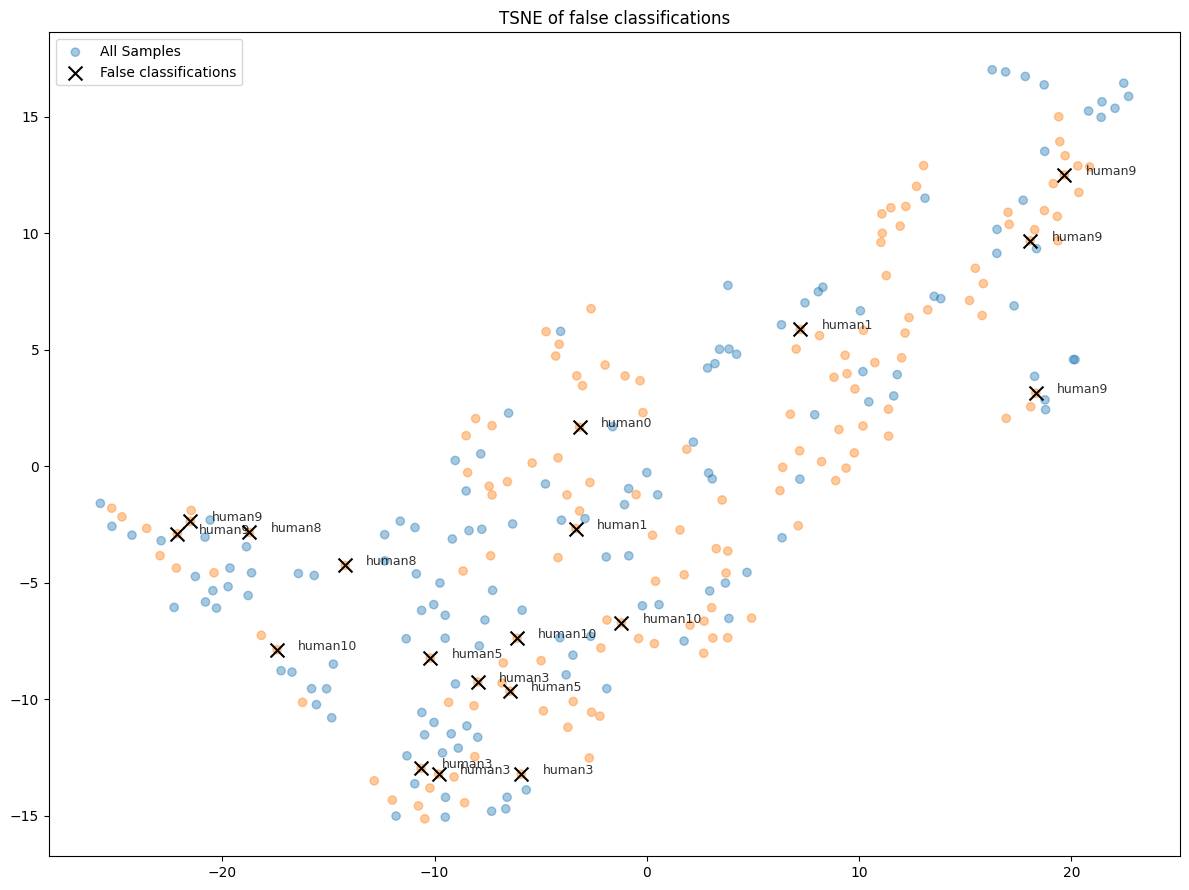

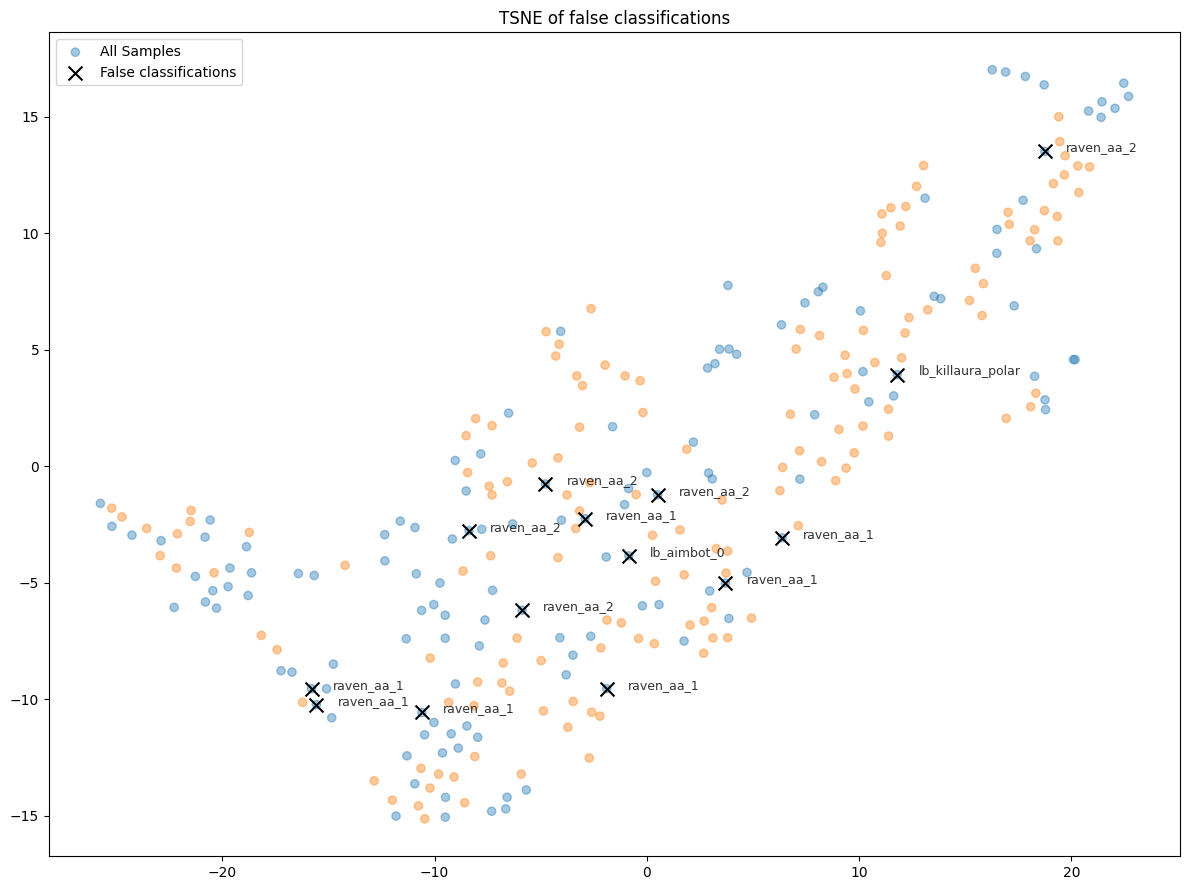

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split


# ===============================
# Here we will visualize the misclassification points using TSNE
# ===============================

# Split train/test, stratified by config
X = features_df.drop(columns=['human'])
y = features_df['human']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=features_df['config'],
    random_state=42
)

# Keep config labels for test set only
config_labels_test = X_test['config'].values
X_test = X_test.drop(columns=['config'])

# STEP 2: Train classifier (replace with your best model if needed)
from xgboost import XGBClassifier
model = XGBClassifier(objective='binary:logistic',
                      eval_metric='logloss',
                      random_state=42,
                      max_depth=2,
                      learning_rate = 0.05,
                      n_estimators = 300,
                      reg_alpha=0.1,
                      reg_lambda=2.0)
model.fit(X_train.drop(columns=['config']), y_train)

# STEP 3: Predict and locate false positives
y_pred = model.predict(X_test)
false_positive_mask = (y_test.values == 1) & (y_pred == 0)
false_negatives_mask = (y_test.values == 0) & (y_pred == 1)

for mask in [false_positive_mask, false_negatives_mask]:
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_test_2d = tsne.fit_transform(X_test)

    plt.figure(figsize=(12, 9))
    colors = np.array(['#1f77b4', '#ff7f0e'])  # 0=blue, 1=orange

    plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
                c=colors[y_test.values], alpha=0.4, label='All Samples')

    # Overlay false positives
    fp_points = X_test_2d[mask]
    fp_configs = config_labels_test[mask]

    plt.scatter(fp_points[:, 0], fp_points[:, 1],
                c='black', marker='x', s=100, label='False classifications')

    # Annotate each false positive with config name
    for i, (x, y) in enumerate(fp_points):
        plt.text(x + 1.0, y, fp_configs[i], fontsize=9, color='black', alpha=0.8)

    plt.title("TSNE of false classifications")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [50]:
from sklearn.model_selection import cross_val_score

# Here we run some cross validation to ensure consistency between multiple train/test splits. What if we just got lucky on our split?
# This is especially important because our dataset is super small, since this is a prototype project.
scores = cross_val_score(
    classifier,
    X_df,
    features_df['human'],
    cv=10,
    scoring='accuracy'
)

# On 10 different cross validation folds, we got pretty good accuracy! 80% is not too bad, again can be taken care of with thresholding.
print(f'Lowest accuracy: {(scores.min() * 100):.4f}%')
print(f'Highest accuracy: {(scores.max() * 100):.4f}%')
print(f'Mean accuracy: {(scores.mean() * 100):.4f}%')
print(f'Standard deviation: {(scores.std() * 100):.4f}%')

Lowest accuracy: 67.1429%
Highest accuracy: 92.1429%
Mean accuracy: 79.6542%
Standard deviation: 8.8110%


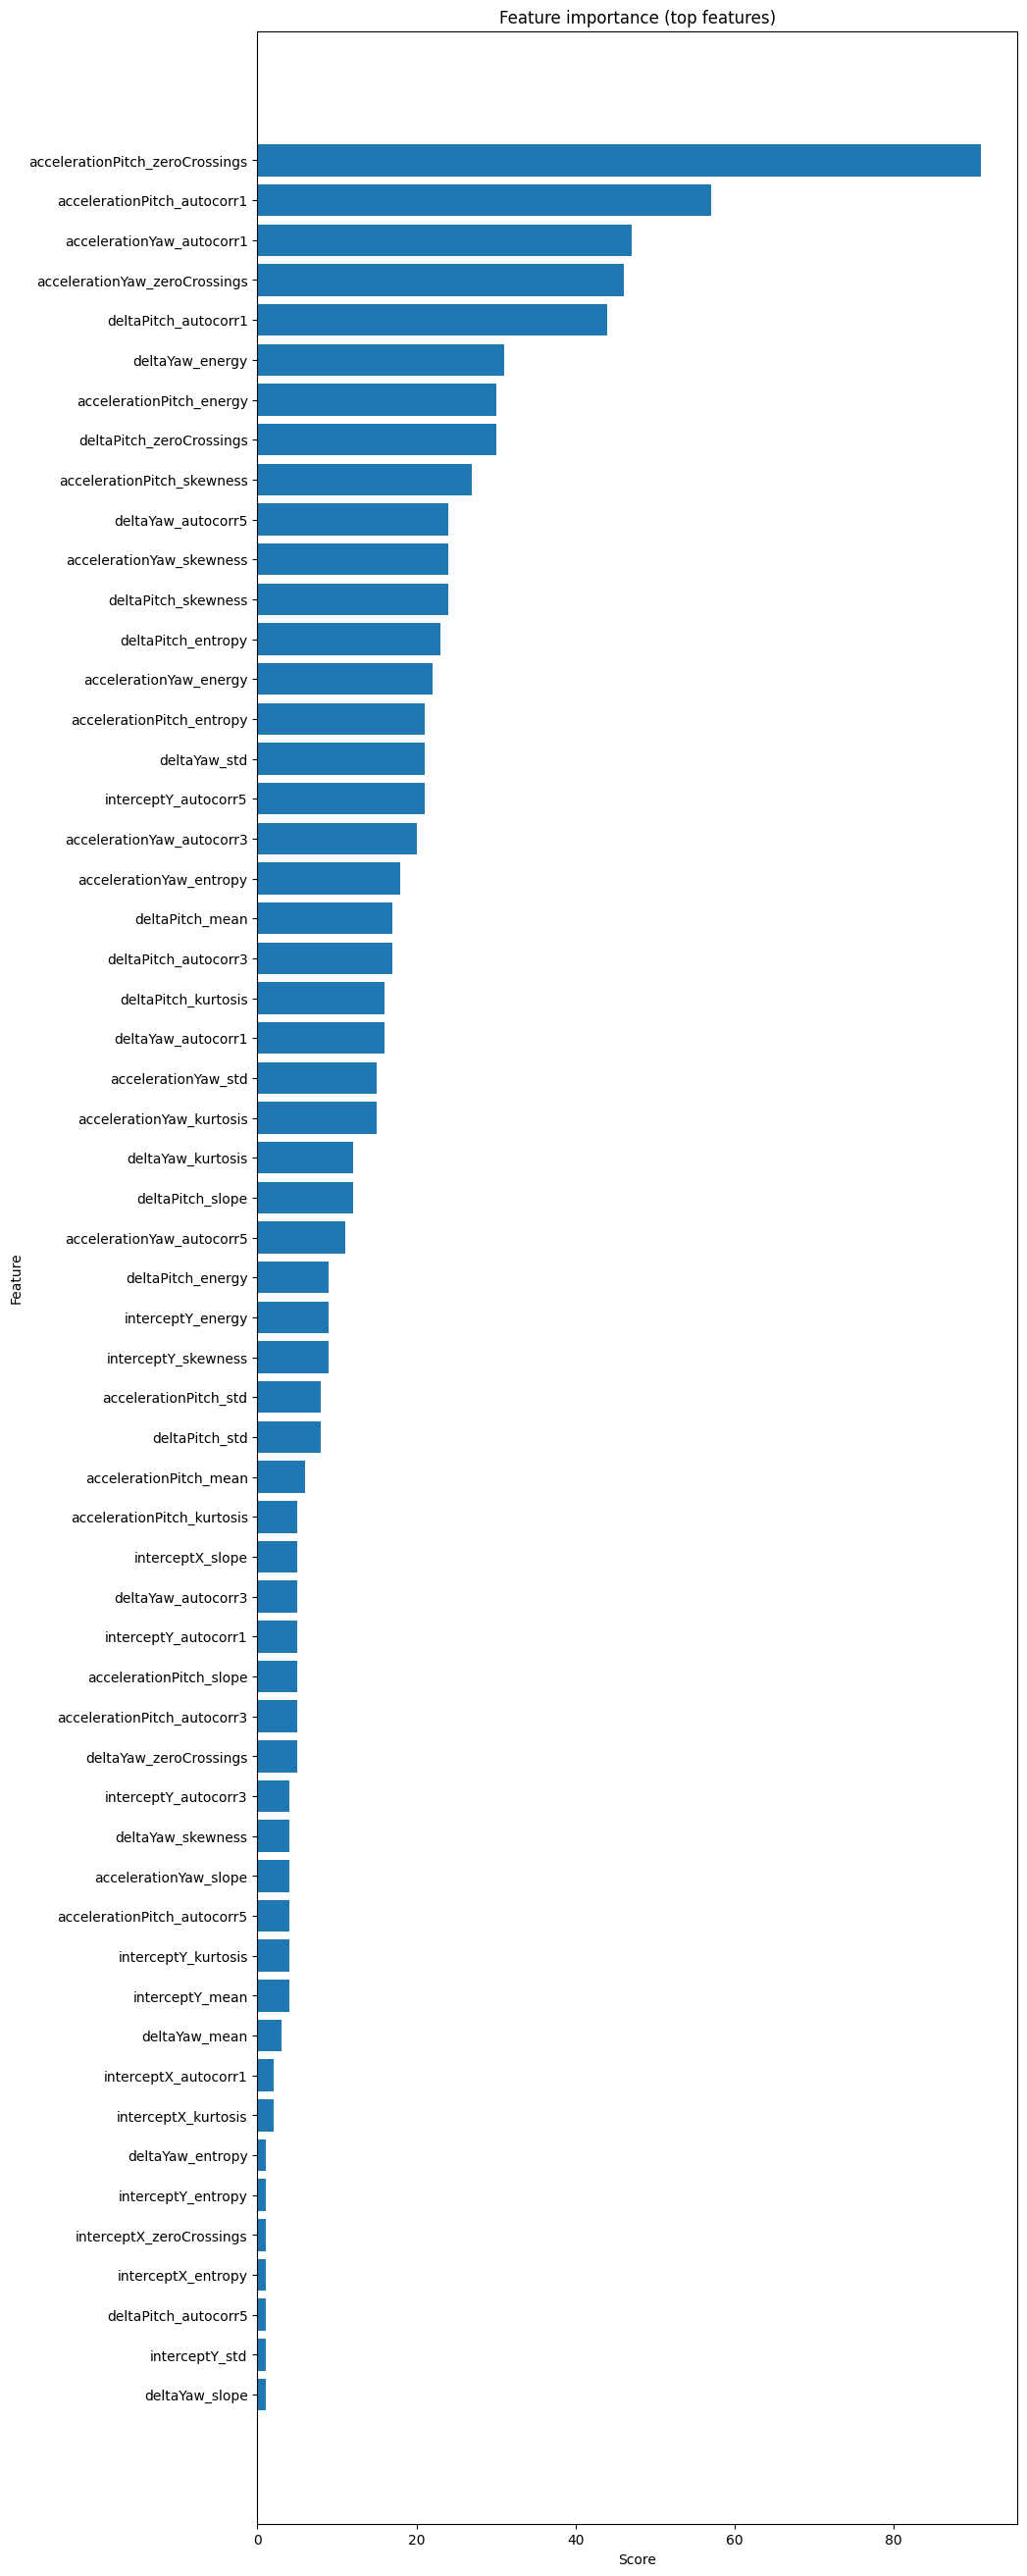

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Get importance dictionary from the trained booster
importance_dict = classifier.get_booster().get_score(importance_type='weight')

# Convert the dictionary to a DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'fscore': list(importance_dict.values())
})

importance_df['fscore'] = importance_df['fscore'].astype(float)
importance_df = importance_df.sort_values(by='fscore', ascending=True)

# Plot the feature importance graph
plt.figure(figsize=(10, len(feature_columns) * 0.5))
bars = plt.barh(
    importance_df['feature'],
    importance_df['fscore']
)

# You will see that some features are very dominant especially on the Y-axis.
# This makes sense as there is generally more difference between how aimbots and humans aim on this axis.
# Due to the nature of aiming, humans and aimbots both require more horizontal movement, leading to more variation and crossover between the two.
plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature importance (top features)')
plt.show()

In [52]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 2.0, 3.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_df, features_df['human'])

print("Best params:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best params: {'reg_lambda': 3.0, 'reg_alpha': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.3}
Best score: 0.7686328725038403


In [53]:
import joblib

# We need to save our model, scaler, and feature order to load on the inference server.
joblib.dump(classifier, "visient_model.pkl")
joblib.dump(scaler, "visient_scaler.pkl")
joblib.dump(feature_columns, "trained_feature_order.pkl")

['trained_feature_order.pkl']

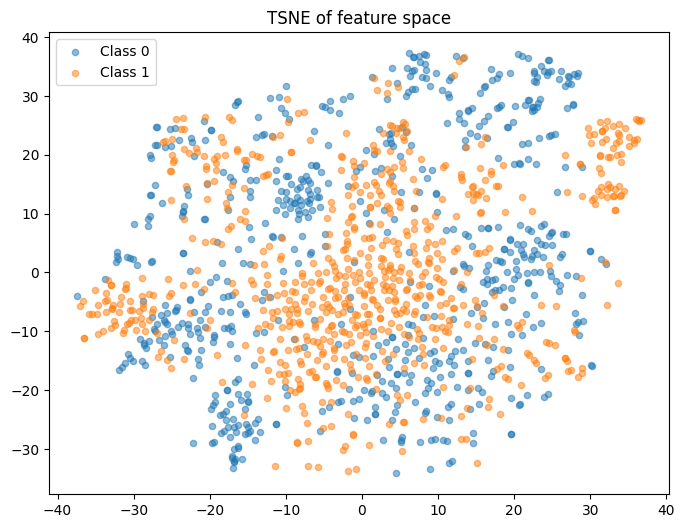

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# TSNE is important so we can visualize the separation between clusters in our profile.
# Our data has clear clusters with little overlap. The dataset is pretty easy to solve.
# A larger dataset is necessary to advance the live performance of this project in the future.
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    max_iter=1000
)

X_embedded = tsne.fit_transform(X_df)

# Plot
plt.figure(figsize=(8, 6))

for label in np.unique(features_df['human']):
    mask = features_df['human'] == label
    plt.scatter(
        X_embedded[mask, 0],
        X_embedded[mask, 1],
        label=f"Class {label}",
        alpha=0.5,
        s=20
    )

plt.legend()
plt.title("TSNE of feature space")
plt.show()
